# Tutorial 8: Spatial-Mux-seq (Mouse embryo)

This tutorial demonstrates cross-modal integration analysis of a mouse embryo spatial-Mux-seq dataset (2,133 spatial spots) using DePass. 

DePass successfully integrated this four-modality Spatial-mux-seq dataset that encompasses Histone modifications (H3K4me3, H3K27me3), ATAC, and RNA, demonstrating its flexibility. 

### Preparation

In [ ]:
import scanpy as sc
import torch
import random
import pandas as pd
import numpy as np
import os
import warnings

warnings.filterwarnings("ignore")

from DePass.utils import *
fix_seed(2024)  

# Environment configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

os.environ['R_HOME'] = '/home/jyx/anaconda3/envs/DePass/lib/R'

path = '../data/dataset_Spatial_Mux_seq'
os.mkdir(path) if not os.path.exists(path) else print(f"The directory '{path}' already exists.\n")

The directory '/home/jyx/DePass-main/outputs/dataset_Spatial_Mux_seq/run' already exists.



### Loading and Preprocessing

In [ ]:
key_gene_list = [
      "E2f2",
      "Sox2", 
      "Neurod2",
      "Pou4f1", 
      "Ank3",
      "Gria2", 
      "Hand2", 
      "Gfi1b",
      'Myh6',
      'Afp',# liver,
      "Hoxc4", 
      "Nprl3"
]

In [ ]:
# read data
adata_omics1 = sc.read_h5ad('../data/dataset_Spatial_Mux_seq/E13_50_3_RNA.h5ad')
adata_omics2 = sc.read_h5ad('../data/dataset_Spatial_Mux_seq/E13_50_3_ATAC.h5ad')
adata_omics3 = sc.read_h5ad('../data/dataset_Spatial_Mux_seq/E13_50_3_H3K4me3.h5ad')
adata_omics4 = sc.read_h5ad('../data/dataset_Spatial_Mux_seq/E13_50_3_H3K27me3.h5ad')

preprocess_data(adata=adata_omics1,modality='rna',n_top_genes=3000, gene_list=key_gene_list) 
# For this dataset, the ATAC, H3K4me3 and H3K27me3 data are all processed as gene scores, so the RNA preprocessing method is used.
preprocess_data(adata=adata_omics2,modality='rna',n_top_genes=3000, gene_list=key_gene_list) 
preprocess_data(adata=adata_omics3,modality='rna',n_top_genes=3000, gene_list=key_gene_list) 
preprocess_data(adata=adata_omics4,modality='rna',n_top_genes=3000, gene_list=key_gene_list) 

adata_omics1.obsm['input_feat'] = adata_omics1.obsm['X_norm'].copy()
adata_omics2.obsm['input_feat'] = adata_omics2.obsm['X_norm'].copy()
adata_omics3.obsm['input_feat'] = adata_omics3.obsm['X_norm'].copy()
adata_omics4.obsm['input_feat'] = adata_omics4.obsm['X_norm'].copy()

data = {'rna': adata_omics1, 'atac':adata_omics2,'H3K4me3': adata_omics3, 'H3K27me3': adata_omics4}

### Training the model

In [ ]:
from DePass.model import DePass
model = DePass(data, data_type='spatial',device=device)
model.train()

[Config]
Modalities: 4 | Data: spatial | Device: NVIDIA GeForce RTX 4090 

[Initializing]
Graph Construction : Running...
Graph Construction : Done!
Data Enhancement : Running...
Data Enhancement : Done!

[Training]
Model training starts...


100%|██████████| 200/200 [00:04<00:00, 45.09it/s]


Model training finished!



In [ ]:
adata = adata_omics1.copy()
adata.obsm['DePass'] = model.embedding
adata.obsm['alpha'] = model.alpha 
adata.obsm['x1_enh'] = model.x1_enh

### Detect spatial domain 

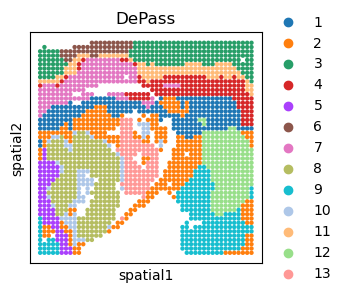

In [ ]:
from DePass.utils import *
clustering(adata=adata,n_clusters=13,key='DePass',add_key='DePass',method='mclust',use_pca=True)

from DePass.analyze_utils import *
plot_spatial(
    adata,
    color='DePass',
    save_path=path,
    save_name='DePass',
    title="DePass",
    s=40,
    dpi=300,
    frameon=True,
    format='pdf',
    show=True,
)